# **Credit Card Fraud Detection**
> [Simple Credit card Fraud Detection 95% Accuracy by KRUTARTH DARJI](https://www.kaggle.com/code/krutarthhd/simple-credit-card-fraud-detection-95-accuracy)

## **Data field**
- `V1`, `V2`,...,`V28` : the result of a PCA transformation
- `Time` : the seconds elapsed between each transaction and the first transaction in the dataset. 
- `Amount` : the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
- `Class` : the response variable and it takes value 1 in case of fraud and 0 otherwise.

  - This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 
  - The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D
from tensorflow.keras.optimizers import Adam

%matplotlib inline

## 1. Gathering the data and assessing the data

In [2]:
df = pd.read_csv('../input/creditcardfraud/creditcard.csv')

print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.Class.unique()

array([0, 1])

## 2. Uneven class distribution

In [5]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
nf = df[df.Class==0]
f = df[df.Class==1]

In [7]:
print(nf.shape)
print(f.shape)

(284315, 31)
(492, 31)


## 3. Extracting random entries of class-0
- Total entries are 1.5* NO. of class-1 entries

In [8]:
nf = nf.sample(738)

## 4. Creating new dataframe

In [9]:
data = f.append(nf, ignore_index=True)

In [10]:
print(data.shape)

(1230, 31)


In [11]:
X = data.drop(['Class'],axis=1)
y = data['Class']

## 5. Train-Test Split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

In [13]:
print("Shape of train X:", x_train.shape)
print("Shape of train y:", y_train.shape)
print("Shape of test X:", x_test.shape)
print("Shape of test X:", y_test.shape)

Shape of train X: (984, 30)
Shape of train y: (984,)
Shape of test X: (246, 30)
Shape of test X: (246,)


## 6. Applying StandardScaler to obtain all the features in similar range

In [14]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## 7. Reshaping the input to 3D.

In [16]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

## 8. CNN model

In [17]:
model = Sequential()
model.add(Conv1D(32,2,activation='relu', input_shape = x_train[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,2,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 32)            96        
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 29, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0

## 9. Compiling and Fiting

In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test,y_test))

Train on 984 samples, validate on 246 samples
Epoch 1/20
984/984 [==============================] - 2s 2ms/sample - loss: 0.7522 - accuracy: 0.6606 - val_loss: 0.5791 - val_accuracy: 0.8130
Epoch 2/20
984/984 [==============================] - 0s 251us/sample - loss: 0.4833 - accuracy: 0.8303 - val_loss: 0.5069 - val_accuracy: 0.7967
Epoch 3/20
984/984 [==============================] - 0s 260us/sample - loss: 0.3391 - accuracy: 0.8740 - val_loss: 0.4552 - val_accuracy: 0.8211
Epoch 4/20
984/984 [==============================] - 0s 265us/sample - loss: 0.3417 - accuracy: 0.8872 - val_loss: 0.4106 - val_accuracy: 0.8699
Epoch 5/20
984/984 [==============================] - 0s 249us/sample - loss: 0.3008 - accuracy: 0.9065 - val_loss: 0.3672 - val_accuracy: 0.9065
Epoch 6/20
984/984 [==============================] - 0s 246us/sample - loss: 0.2785 - accuracy: 0.9085 - val_loss: 0.3249 - val_accuracy: 0.9146
Epoch 7/20
984/984 [==============================] - 0s 290us/sample - loss: 0.

In [21]:
def plotLearningCurve(history,epochs):
    epochRange = range(1,epochs+1)
    plt.plot(epochRange,history.history['accuracy'])
    plt.plot(epochRange,history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

    plt.plot(epochRange,history.history['loss'])
    plt.plot(epochRange,history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

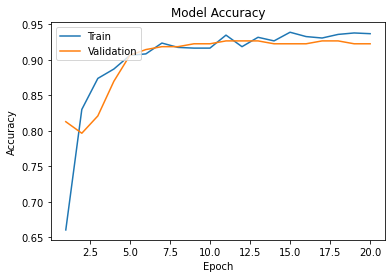

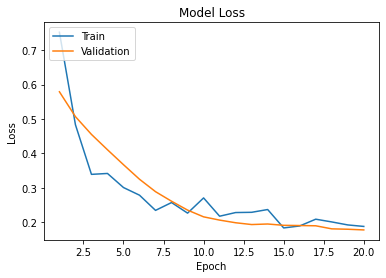

In [22]:
plotLearningCurve(history,20)